In [5]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error
import tensorflow as tf
import keras
from keras.backend import sigmoid
from keras.models import Sequential
from keras import models, layers, backend, optimizers
from keras.layers import Dropout, BatchNormalization, Flatten, Dense
from keras.callbacks import EarlyStopping
from tensorflow.keras.layers import Conv1D
from tensorflow.keras.layers import MaxPooling1D
import time
from math import sqrt


In [16]:
file = "DGS10_cleaned2.csv"
df = pd.read_csv(file, index_col='DATE', parse_dates=True)
df

,10Y_Rate
DATE,
2000-01-03,6.58
2000-01-04,6.49
2000-01-05,6.62
2000-01-06,6.57
2000-01-07,6.52
...,...
2023-12-08,4.23
2023-12-11,4.23
2023-12-12,4.20


In [17]:
def CreateLaggedSequence(data, lag):
    # Create lists for PredictorSequences and ResponseVariables to store data respectively
    PredictorSequences, ResponseVariables = list(), list()
    for i in range(len(data)):
        # mark the range of the sequence
        end_i = i + lag
        # check when the data ends
        if end_i+1 > len(data):
            # check if the end of the index of the sequence is greater than the length of the input data
            break
        # get the predictors and responses
        PredictorSequence = data[i:end_i]
        ResponseVariable = data[end_i]
        # append them to the lists
        PredictorSequences.append(PredictorSequence)
        ResponseVariables.append(ResponseVariable)
        # print(end_i)
    return np.array(PredictorSequences), np.array(ResponseVariables)

Lagged sequences are used to predict future values based on past data, shifted by a certain number of time steps. By adding the lag value to the current index i, the end point can be defined. Inside the loop, there is a sliding window from start of i toe end_i.

Predictor sequence is a portion of the input data starting from i to end_i and will be used to for the training portion of the model. Response variable will typically be the next observation in the entire sequence and is your output target. 

In [18]:
# Get the univariate series from df
X = df['10Y_Rate']
np_X = np.array(X)
# Create the lagged values for the series (50 lags)
X, y = CreateLaggedSequence(np_X, 50)
lag = X.shape[1]
NumberOfFeatures = 1 # for univariate input
# reshape it for the process
X = X.reshape(X.shape[0], X.shape[1], NumberOfFeatures) 
# CNN architecture requires a reshape - (batch_size, sequence_length, number_of_features)
X.shape, y.shape, len(X), len(y)

((5943, 50, 1), (5943,), 5943, 5943)

The series being used is the 10 year rate from the df. Since NumPy arrays are normally used for numerical computations and highly compatible across libraries, the series is converted. Capturing possible longer term implications, a lag of 50 is used to begin for pattern learning. 

In [19]:
# Split the train and test sets using lag of 50 
x_train, x_test = X[:-50], X[-50:]
y_train, y_test = y[:-50], y[-50:]
x_train.shape, x_test.shape, y_train.shape, y_test.shape

((5893, 50, 1), (50, 50, 1), (5893,), (50,))

In [20]:
#Activation function
def swish(x, beta = 1):
    return (x * sigmoid(beta * x))

from tensorflow.keras.utils import get_custom_objects
from keras.layers import Activation
get_custom_objects().update({'swish': Activation(swish)})

Defines a new activation function named swish. Activation functions are mathematical functions applied to the output of a neural network layer to introduce non-linearity into the model.

In [21]:
#Timer to measure execution time 
start = time.time()

# Initalize sequential model
backend.clear_session()
model = Sequential()

model.add(Conv1D(filters=233, kernel_size=3, padding='same', activation=tf.keras.backend.sin, input_shape=(lag, NumberOfFeatures)))
model.add(Conv1D(filters=233, kernel_size=3, padding='same', activation=tf.keras.backend.sin))

model.add(Flatten())

model.add(layers.Dense(3*2**8, activation=tf.keras.backend.sin, kernel_initializer='he_uniform'))
model.add(Dropout(0.5)) 
model.add(layers.Dense(1, activation='swish'))


optimizer = optimizers.Adam(learning_rate=0.000007)
model.compile(optimizer=optimizer, loss='mse', metrics=['mae'])
model.summary()

# Fitting the model
history = model.fit(x_train, y_train,
            epochs = 2**10,
            batch_size = 3615,
            validation_split = 0.20,
            verbose = 1,
            callbacks=[EarlyStopping(monitor='val_mae', patience=2**6, restore_best_weights = True)]) # restore the best values

#Evaluation of model
test_loss, test_acc = model.evaluate(x_test, y_test)
print('test_acc:', test_acc)

# End timer and print the total time passed
end = time.time()
print("Total time:", end-start, "seconds")

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d (Conv1D)             (None, 50, 233)           932       
                                                                 
 conv1d_1 (Conv1D)           (None, 50, 233)           163100    
                                                                 
 flatten (Flatten)           (None, 11650)             0         
                                                                 
 dense (Dense)               (None, 768)               8947968   
                                                                 
 dropout (Dropout)           (None, 768)               0         
                                                                 
 dense_1 (Dense)             (None, 1)                 769       
                                                                 
Total params: 9112769 (34.76 MB)
Trainable params: 91127

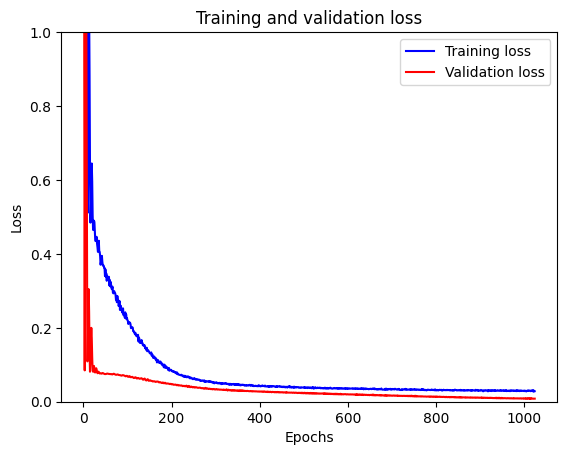

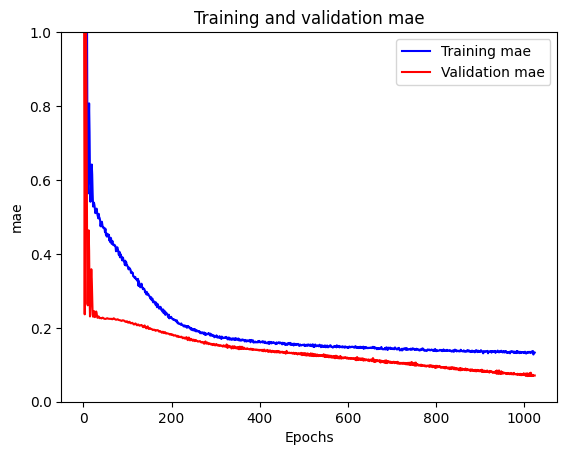

In [31]:
# Gather history of fitting

history_dict = history.history
loss_values = history_dict['loss']
val_loss_values = history_dict['val_loss']
mae_values = history_dict['mae']
val_mae_values = history_dict['val_mae']
epochs = range(1, len(history_dict['mae']) + 1)

# Plot the training and validation losses
plt.plot(epochs, loss_values, label = 'Training loss', color='blue')
plt.plot(epochs, val_loss_values, label = 'Validation loss', color='red')
plt.ylim(0,1)
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()
# Plot the training and validation mae
plt.plot(epochs, mae_values, label = 'Training mae', color='blue')
plt.plot(epochs, val_mae_values, label = 'Validation mae', color='red')
plt.ylim(0,1)
plt.title('Training and validation mae')
plt.xlabel('Epochs')
plt.ylabel('mae')
plt.legend()
plt.show()

With the training loss curve, we can see there is a decreasing trend over the period of epochs. This is a good indication that the model is learning from the training data and minimzing the loss function. After the initial loss, the subsequent curve has a decreasingly smooth and continuous nature. 

Similiarly, the validation loss curve shows a similiar pattern to the training loss curve. This means the model is generalizing well to new data. There is no overfitting because, both curves are decreasing and eventually converge to similar values with no sudden rises. It can be concluded that the model has learned the underlying pattern well. 

In [23]:
yhat = model.predict(x_test, verbose=1)

2/2 [==============================] - 1s 89ms/step


In [26]:
# Convert the predictions series
predictions = pd.Series(yhat.reshape((50)), index=df['10Y_Rate'].index[-50:])
actuals = df['10Y_Rate'][-50:]


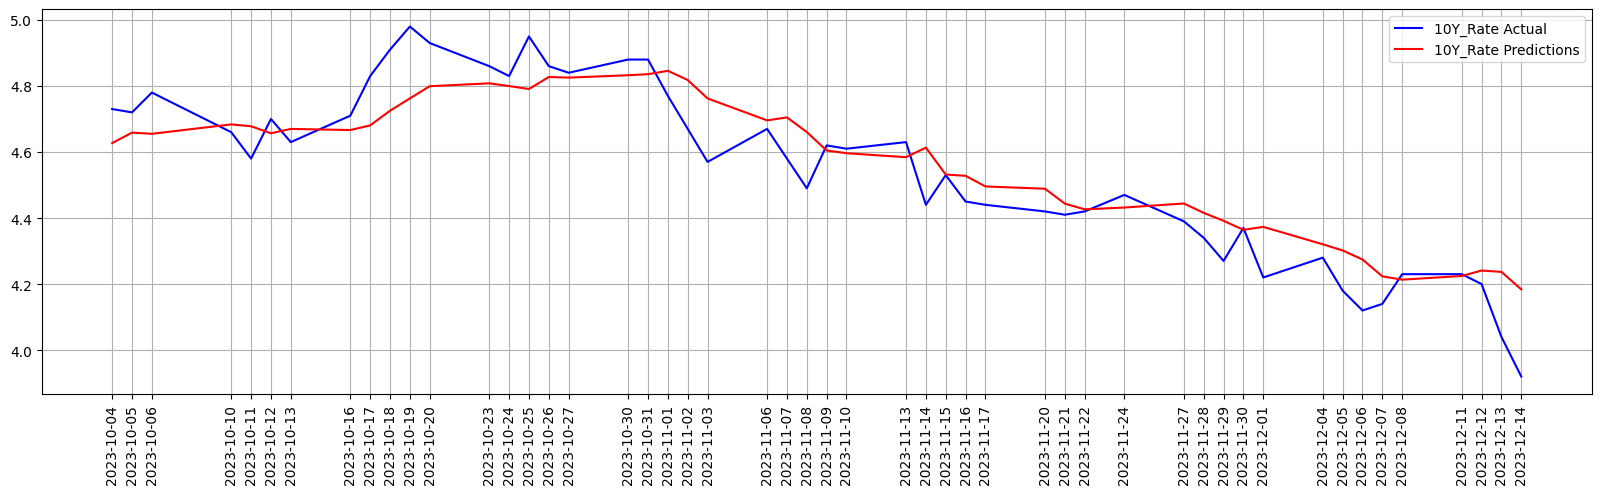

Test RMSE: 0.10627


In [28]:
plt.figure(figsize=(20,5))
plt.plot(actuals.index, actuals, color='blue')
plt.plot(actuals.index, predictions, color='red')
plt.legend(('10Y_Rate Actual', '10Y_Rate Predictions'))
plt.xticks(actuals.index, rotation=90)
plt.grid(True)
plt.show()

rmse = sqrt(mean_squared_error(actuals, predictions))
print('Test RMSE: %.5f' % rmse)

When comparing the results to the base ARIMA model, it can be seen the CNN's RMSE of 0.10627 is higher than ARIMA's 0.08549. Personally, I will be exploring how to decrease the RMSE using different modelling techniques to begin. As I become more comfortable, more features related to the change rate of specific sources of systemic liquidity can be tested. 